In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cPickle as pickle
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from engine.simulator import FleetSimulator
from engine.lp import Agent
import experiment as ex
plt.style.use('ggplot')

In [2]:
def plot(result):
    plt.figure(figsize=(10, 6))
    index = result.index
    plt.subplot(211)
    plt.ylabel('total_count')
    plt.plot(index, result.requests, label='demand')
    plt.plot(index, result.reject, label='reject')
    plt.plot(index, result.dispatch, label='dispatch')
    plt.plot(index, result.resource, label='resource')
    plt.legend()
    plt.subplot(212)
    plt.ylabel('wait time')
    plt.plot(index, result.wait_time/(result.requests-result.reject))
    return plt

In [3]:
GRAPH_PATH = 'data/pickle/nyc_network_graph.pkl'
TRIP_PATH = 'data/nyc_taxi/trips_2016-05.csv'
DEMAND_MODEL_PATH = 'data/pickle/demand_predictor.pkl'
ETA_MODEL_PATH = 'data/pickle/triptime_predictor.pkl'
GEOHASH_TABLE_PATH = 'data/table/zones.csv'
ETA_TABLE_PATH = 'data/table/eta.csv'
PDEST_TABLE_PATH = 'data/table/pdest.csv'
SCORE_PATH = 'data/results/score_lp.csv'

SAMPLE_SIZE = 500000
NUM_FLEETS = 8000
NO_OP_STEPS = 1
CYCLE = 15

In [4]:
with open(GRAPH_PATH, 'r') as f:
    G = pickle.load(f)
with open(ETA_MODEL_PATH, 'r') as f:
    eta_model = pickle.load(f)
with open(DEMAND_MODEL_PATH, 'r') as f:
    demand_model = pickle.load(f)

geohash_table = pd.read_csv(GEOHASH_TABLE_PATH, index_col='geohash')
eta_table = pd.read_csv(ETA_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])
pdest_table = pd.read_csv(PDEST_TABLE_PATH, index_col=['dayofweek', 'hour', 'pickup_zone'])

In [5]:
trips, dayofweek, minofday, duration = ex.load_trips(TRIP_PATH, SAMPLE_SIZE)
env = FleetSimulator(G, eta_model, CYCLE, CYCLE)
num_steps = 1440 / CYCLE

In [5]:
%%time
env.reset(NUM_FLEETS, trips, dayofweek, minofday)    
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
score = ex.run(env, None, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (9 elapsed) // REQ: 26430 / REJ: 2881 / AWT: 4.5 / DSP: 0.00 / RWD: 76.8
t = 120 (9 elapsed) // REQ: 23090 / REJ: 4489 / AWT: 5.4 / DSP: 0.00 / RWD: 33.5
t = 180 (8 elapsed) // REQ: 18750 / REJ: 3772 / AWT: 5.6 / DSP: 0.00 / RWD: 25.2
t = 240 (7 elapsed) // REQ: 14495 / REJ: 3250 / AWT: 5.7 / DSP: 0.00 / RWD: 18.3
t = 300 (5 elapsed) // REQ: 7418 / REJ: 363 / AWT: 4.2 / DSP: 0.00 / RWD: 10.6
t = 360 (4 elapsed) // REQ: 3905 / REJ: 550 / AWT: 6.2 / DSP: 0.00 / RWD: 6.6
t = 420 (4 elapsed) // REQ: 4701 / REJ: 909 / AWT: 6.7 / DSP: 0.00 / RWD: 7.5
t = 480 (5 elapsed) // REQ: 6594 / REJ: 2021 / AWT: 7.3 / DSP: 0.00 / RWD: 10.1
t = 540 (7 elapsed) // REQ: 9905 / REJ: 3394 / AWT: 6.8 / DSP: 0.00 / RWD: 14.9
t = 600 (8 elapsed) // REQ: 14705 / REJ: 5560 / AWT: 5.8 / DSP: 0.00 / RWD: 20.4
t = 660 (9 elapsed) // REQ: 19635 / REJ: 6862 / AWT: 4.8 / DSP: 0.00 / RWD: 26.7
t = 720 (10 elapsed) // REQ: 22605 / REJ: 7694 / AWT: 4.5 / DSP: 0.00 / RWD: 31.3
t = 780 (10 elapsed) // REQ: 24023 / R

In [7]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=2, cost=0, penalty=25.0, svv_rate=1.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (96 elapsed) // REQ: 26430 / REJ: 2683 / AWT: 4.4 / DSP: 0.10 / RWD: 76.4
t = 120 (205 elapsed) // REQ: 23090 / REJ: 3814 / AWT: 5.4 / DSP: 0.11 / RWD: 34.0
t = 180 (308 elapsed) // REQ: 18750 / REJ: 2932 / AWT: 5.5 / DSP: 0.12 / RWD: 26.0
t = 240 (412 elapsed) // REQ: 14495 / REJ: 2118 / AWT: 5.5 / DSP: 0.12 / RWD: 19.6
t = 300 (511 elapsed) // REQ: 7418 / REJ: 47 / AWT: 3.0 / DSP: 0.11 / RWD: 9.9
t = 360 (607 elapsed) // REQ: 3905 / REJ: 0 / AWT: 3.9 / DSP: 0.08 / RWD: 6.9
t = 420 (701 elapsed) // REQ: 4701 / REJ: 64 / AWT: 4.2 / DSP: 0.09 / RWD: 8.4
t = 480 (806 elapsed) // REQ: 6594 / REJ: 354 / AWT: 5.3 / DSP: 0.12 / RWD: 11.9
t = 540 (898 elapsed) // REQ: 9905 / REJ: 1234 / AWT: 5.6 / DSP: 0.09 / RWD: 18.1
t = 600 (990 elapsed) // REQ: 14705 / REJ: 3463 / AWT: 5.0 / DSP: 0.09 / RWD: 23.8
t = 660 (1081 elapsed) // REQ: 19635 / REJ: 4764 / AWT: 4.5 / DSP: 0.07 / RWD: 30.0
t = 720 (1167 elapsed) // REQ: 22605 / REJ: 5731 / AWT: 4.2 / DSP: 0.04 / RWD: 34.8
t = 780 (1253 elapse

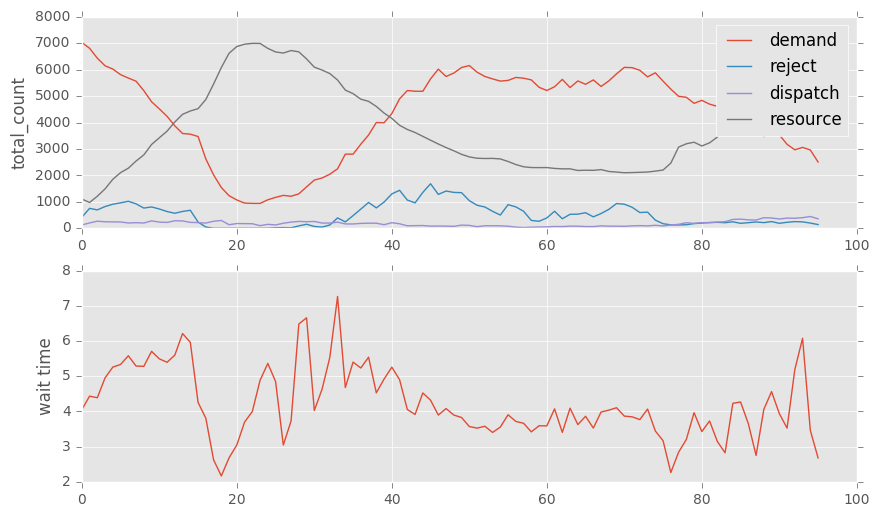

In [8]:
plot(score);

In [6]:
env.reset(NUM_FLEETS, trips, dayofweek, minofday)

agent = Agent(geohash_table, eta_table, pdest_table, demand_model, CYCLE,
              T=3, cost=0, penalty=25.0)
for _ in range(NO_OP_STEPS):
    _, requests, _, _, _ = env.step()
agent.reset(requests, env.dayofweek, env.minofday)
score = ex.run(env, agent, num_steps, average_cycle=4)
ex.describe(score)

t = 60 (253 elapsed) // REQ: 26430 / REJ: 2143 / AWT: 4.4 / DSP: 0.40 / RWD: 74.7
t = 120 (582 elapsed) // REQ: 23090 / REJ: 1264 / AWT: 5.3 / DSP: 0.65 / RWD: 33.6
t = 180 (888 elapsed) // REQ: 18750 / REJ: 10 / AWT: 4.0 / DSP: 0.74 / RWD: 25.8
t = 240 (1130 elapsed) // REQ: 14495 / REJ: 0 / AWT: 3.2 / DSP: 0.62 / RWD: 19.6
t = 300 (1305 elapsed) // REQ: 7418 / REJ: 0 / AWT: 1.6 / DSP: 0.35 / RWD: 8.2
t = 360 (1439 elapsed) // REQ: 3905 / REJ: 0 / AWT: 1.8 / DSP: 0.11 / RWD: 7.3
t = 420 (1582 elapsed) // REQ: 4701 / REJ: 3 / AWT: 2.3 / DSP: 0.14 / RWD: 8.7
t = 480 (1777 elapsed) // REQ: 6594 / REJ: 55 / AWT: 2.7 / DSP: 0.23 / RWD: 12.2
t = 540 (2025 elapsed) // REQ: 9905 / REJ: 0 / AWT: 2.9 / DSP: 0.31 / RWD: 18.4
t = 600 (2319 elapsed) // REQ: 14705 / REJ: 14 / AWT: 3.1 / DSP: 0.40 / RWD: 26.8
t = 660 (2651 elapsed) // REQ: 19635 / REJ: 0 / AWT: 2.5 / DSP: 0.44 / RWD: 35.5
t = 720 (2948 elapsed) // REQ: 22605 / REJ: 39 / AWT: 2.4 / DSP: 0.39 / RWD: 43.1
t = 780 (3132 elapsed) // REQ:

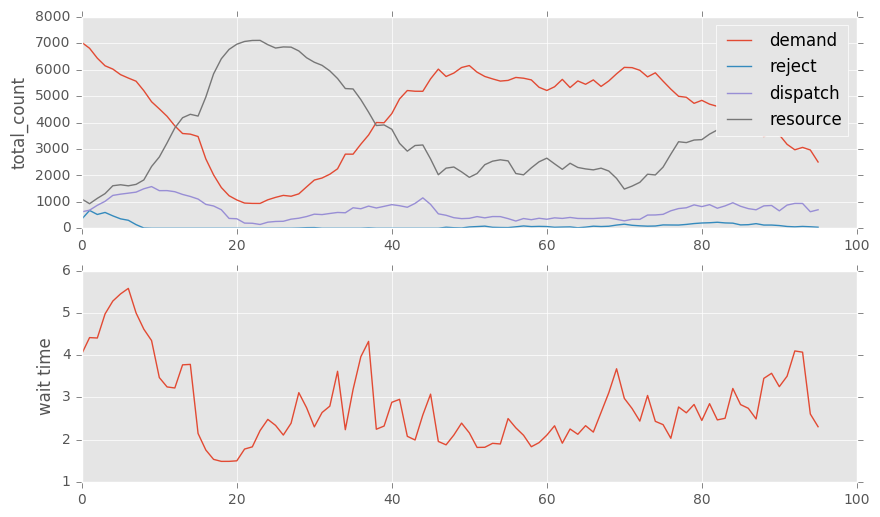

In [7]:
plot(score);